In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, ttest_ind, fisher_exact

In [2]:
data = pd.read_pickle("kulich.pkl")
data['GAP_IN_YEAR'] = data['I_EPI21_INFCLIN_MHSTDAT'].isnull()

missing_date_2 = data[(data['GAP_IN_YEAR'] == True) & (data['uI_EPI21_INFPER_MHSTDAT'] == 'Период 2 (с 2016 - по сегодняшний день)')].index
missing_date_1 = data[(data['GAP_IN_YEAR'] == True) & (data['uI_EPI21_INFPER_MHSTDAT'] != 'Период 2 (с 2016 - по сегодняшний день)')].index

data['I_EPI21_INFCLIN_MHSTDAT'].loc[missing_date_2] = '2019-01-01'
data['I_EPI21_INFCLIN_MHSTDAT'].loc[missing_date_1] = '2012-01-01'

data['AGE'] = ((pd.to_datetime(data['I_EPI21_INFCLIN_MHSTDAT']) - pd.to_datetime(data['I_EPI22_BRTHDAT']))/np.timedelta64(1, 'Y')).astype(int)


C:\Users\mishka\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### возраст

In [5]:
success = data[data.I_EPI28_PREG_RPORRES == 1]['AGE'].to_numpy()
failure = data[data.I_EPI28_PREG_RPORRES == 0]['AGE'].to_numpy()

In [6]:
mannwhitneyu(success, failure)[1]

1.9234862322715067e-17

In [7]:
# если считать распределение за нормальное
ttest_ind(success, failure)[1]

8.674288786230679e-20

In [8]:
print("успехи: %f+-%f \t неуспехи: %f+-%f" %(success.mean(), success.std(), failure.mean(), failure.std()))

успехи: 31.775237+-4.666305 	 неуспехи: 32.887869+-5.027784


### амг

In [48]:
success = data[data.I_EPI28_PREG_RPORRES == 1]['АМГ (нг/мл)'].apply(lambda x: min(x) if type(x) == np.ndarray else x).to_numpy()
failure = data[data.I_EPI28_PREG_RPORRES == 0]['АМГ (нг/мл)'].apply(lambda x: min(x) if type(x) == np.ndarray else x).to_numpy()
mannwhitneyu(success, failure, nan_policy='omit')[1]

3.670986360370023e-15

In [49]:
success = success[~np.isnan(success)]
failure = failure[~np.isnan(failure)]
print("успехи: %f+-%f \t неуспехи: %f+-%f" %(success.mean(), success.std(), failure.mean(), failure.std()))

успехи: 3.216068+-2.948904 	 неуспехи: 2.750081+-2.554033


(array([998., 556., 134.,  49.,  27.,  12.,   8.,   8.,   1.,   3.]),
 array([1.0000e-02, 2.6430e+00, 5.2760e+00, 7.9090e+00, 1.0542e+01,
        1.3175e+01, 1.5808e+01, 1.8441e+01, 2.1074e+01, 2.3707e+01,
        2.6340e+01]),
 <BarContainer object of 10 artists>)

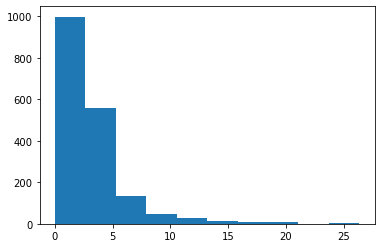

In [32]:
plt.hist(success)

### имт

In [33]:
success = data[data.I_EPI28_PREG_RPORRES == 1]['I_EPI22_BMI_VSORRES'].to_numpy()
failure = data[data.I_EPI28_PREG_RPORRES == 0]['I_EPI22_BMI_VSORRES'].to_numpy()
print("pval:", mannwhitneyu(success, failure, nan_policy='omit')[1])
success = success[~np.isnan(success)]
failure = failure[~np.isnan(failure)]
print("успехи: %f+-%f \t неуспехи: %f+-%f" %(success.mean(), success.std(), failure.mean(), failure.std()))

pval: 0.10393456802712785
успехи: 23.530120+-3.968529 	 неуспехи: 23.709093+-4.086004


### гормональное лечение

In [34]:
success = data[data.I_EPI28_PREG_RPORRES == 1]['I_EPI23_HORMTREAT_CMDECOD'].to_numpy()
failure = data[data.I_EPI28_PREG_RPORRES == 0]['I_EPI23_HORMTREAT_CMDECOD'].to_numpy()
print("pval:", mannwhitneyu(success, failure, nan_policy='omit')[1])
success = success[~np.isnan(success)]
failure = failure[~np.isnan(failure)]
print("успехи: %f+-%f \t неуспехи: %f+-%f" %(success.mean(), success.std(), failure.mean(), failure.std()))

pval: 0.3336455004978316
успехи: 1.926496+-1.825667 	 неуспехи: 1.890608+-2.189773


In [35]:
print("КОЛ-ВО НАБЛЮДЕНИЙ\nБеременность: %f, Нет беременности: %f" %(len(success[~np.isnan(success)]), len(failure[~np.isnan(failure)])))

КОЛ-ВО НАБЛЮДЕНИЙ
Беременность: 234.000000, Нет беременности: 362.000000


In [63]:
inf_treatment_dur = (data.I_EPI21_INFCLIN_MHSTDAT - data.I_EPI21_INFTHER_MHSTDAT).dropna()
inf_treatment_dur = inf_treatment_dur[inf_treatment_dur > np.timedelta64(0, 'D')]
inf_treatment_dur.shape[0]

518

Тут вычитанием из даты обращения в клинику ВРТ даты начала лечения бесплодия получаем еще меньше женщин, чем при данных горм лечения, но тут p-value 0.05)) То есть стат. значимость. Не знаю, стоит ли брать, не сильна в размерах выборок

In [79]:
total_patients =  data.loc[inf_treatment_dur.index]

success = (inf_treatment_dur[total_patients[total_patients.I_EPI28_PREG_RPORRES == 1].index]/ np.timedelta64(1, 'D')).to_numpy()
failure = (inf_treatment_dur[total_patients[total_patients.I_EPI28_PREG_RPORRES == 0].index]/ np.timedelta64(1, 'D')).to_numpy()
print("pval:", mannwhitneyu(success, failure, nan_policy='omit')[1])
success = success[~np.isnan(success)]
failure = failure[~np.isnan(failure)]
print("успехи (в днях): %f+-%f \t неуспехи (в днях): %f+-%f" %(success.mean(), success.std(), failure.mean(), failure.std()))

pval: 0.005006472959042236
успехи (в днях): 1284.052632+-988.037760 	 неуспехи (в днях): 1605.737705+-1287.282030


In [78]:
print("КОЛ-ВО НАБЛЮДЕНИЙ\nБеременность: %f, Нет беременности: %f" %(len(success[~np.isnan(success)]), len(failure[~np.isnan(failure)])))

КОЛ-ВО НАБЛЮДЕНИЙ
Беременность: 152.000000, Нет беременности: 366.000000


### трубный фактор

In [41]:
#data['tub'] = data.I_EPI23_INFERT_N971_MHOCCUR.replace({Y:1})
la = data.groupby(by = ['I_EPI23_INFERT_N971_MHOCCUR', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

I_EPI23_INFERT_N971_MHOCCUR  I_EPI28_PREG_RPORRES
N                            0                       2415
                             1                       1390
Y                            0                       2048
                             1                       1143
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=0.96965806261241, pvalue=0.5489536993234814)


### отсутствие овуляции

In [42]:
la = data.groupby(by = ['I_EPI23_INFERT_N970_MHOCCUR', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

I_EPI23_INFERT_N970_MHOCCUR  I_EPI28_PREG_RPORRES
N                            0                       3683
                             1                       2030
Y                            0                        777
                             1                        502
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=1.1721640007354293, pvalue=0.013200835556353235)


### маточное

In [43]:
la = data.groupby(by = ['I_EPI23_INFERT_N972_MHOCCUR', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

I_EPI23_INFERT_N972_MHOCCUR  I_EPI28_PREG_RPORRES
N                            0                       3624
                             1                       2122
Y                            0                        838
                             1                        410
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=0.8355696319273708, pvalue=0.006982330544350513)


### цервикальное

In [44]:
la = data.groupby(by = ['I_EPI23_INFERT_N973_MHOCCUR', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

I_EPI23_INFERT_N973_MHOCCUR  I_EPI28_PREG_RPORRES
N                            0                       4352
                             1                       2444
Y                            0                        108
                             1                         87
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=1.4344426259319876, pvalue=0.015428274657170844)


### мужской фактор

In [45]:
la = data.groupby(by = ['I_EPI23_INFERT_N974_MHOCCUR', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

I_EPI23_INFERT_N974_MHOCCUR  I_EPI28_PREG_RPORRES
N                            0                       2399
                             1                       1371
Y                            0                       2064
                             1                       1162
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=0.9851202087538661, pvalue=0.7646858093833284)


### другие формы

In [46]:
la = data.groupby(by = ['I_EPI23_INFERT_N978_MHOCCUR', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

I_EPI23_INFERT_N978_MHOCCUR  I_EPI28_PREG_RPORRES
N                            0                       3763
                             1                       2195
Y                            0                        701
                             1                        335
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=0.8192689259404885, pvalue=0.0056340088191405464)


### неуточненное

In [47]:
la = data.groupby(by = ['I_EPI23_INFERT_N979_MHOCCUR', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

I_EPI23_INFERT_N979_MHOCCUR  I_EPI28_PREG_RPORRES
N                            0                       4177
                             1                       2361
Y                            0                        274
                             1                        163
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=1.0524598323733911, pvalue=0.643613148068743)


### предыдущие роды (имеются ли хотя бы одни роды в анамнезе?)

In [94]:
#здесь НЕТ -- также отсутствие информации
data['pregs'] = data.GRID_EPI22_PREGNANCY_1.notna().replace({True:'Y', False:'N'})
la = data.groupby(by = ['pregs', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

pregs  I_EPI28_PREG_RPORRES
N      0                       3831
       1                       2182
Y      0                        637
       1                        354
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=0.9757110769288326, pvalue=0.7482603793669638)


### выкидыши (были ли самопроизвольные прерывания беременности/замершие беременности в анамнезе)

In [108]:
misc = data.I_EPI22_PREGMISSNN_RPORRES.dropna()
misc = (misc!=0).replace({True:'Y', False:'N'})
data['misc'] = ab
la = data.groupby(by = ['misc', 'I_EPI28_PREG_RPORRES'])['study_name'].count()

st = np.zeros(4).reshape(2, 2)

st[0][0] = la[('Y', 1)]
st[0][1] = la[('N', 1)]
st[1][0] = la[('Y', 0)]
st[1][1] = la[('N', 0)]

print(la, fisher_exact(st), sep = '\n P-VALUE И СТАТИСТИКА\n')

misc  I_EPI28_PREG_RPORRES
N     0                       115
      1                        71
Y     0                       866
      1                       471
Name: study_name, dtype: int64
 P-VALUE И СТАТИСТИКА
SignificanceResult(statistic=0.8809322447386397, pvalue=0.4621001508780061)
